In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read the dataset
# Transform the excel file in csv file
df = pd.read_excel('energy_demand.xlsx')

csv_file_path = 'energy_demand.csv'

df.to_csv(csv_file_path, index = False)

print(df)

            Date  Hour    load          T
0     2012-01-01     0  2872.0  30.666667
1     2012-01-01     1  2698.0  32.000000
2     2012-01-01     2  2558.0  32.666667
3     2012-01-01     3  2444.0  30.000000
4     2012-01-01     4  2402.0  31.000000
...          ...   ...     ...        ...
26300 2014-12-31    20  4012.0  18.000000
26301 2014-12-31    21  3856.0  16.666667
26302 2014-12-31    22  3671.0  17.000000
26303 2014-12-31    23  3499.0  15.333333
26304 2014-12-31    24  3345.0  15.333333

[26305 rows x 4 columns]


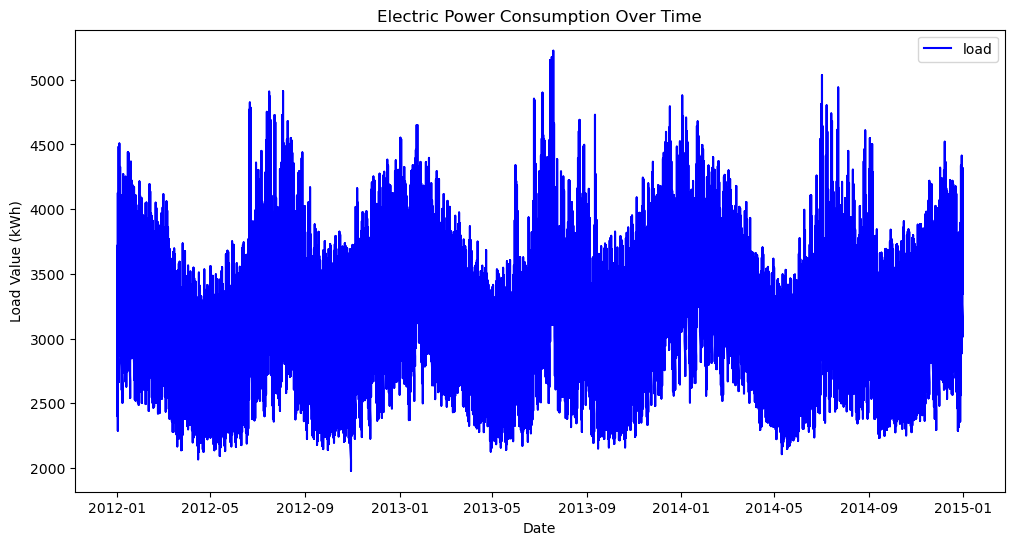

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index for time series plotting
df.set_index('Date', inplace=True)

# Plot the time series of Load values
plt.figure(figsize=(12, 6))
plt.plot(df['load'], label='load', color='blue')
plt.title('Electric Power Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Load Value (kWh)')
plt.legend()
plt.show()

In [4]:
# Data Preparation

# Display columns names
print(df.columns)

# Change the column names
new_column_names = {
    'load' : 'Load Value',
    'T' : 'Temperature'
}

df.rename(columns = new_column_names, inplace = True)

print("Update columns : ")
print(df.columns)

Index(['Hour', 'load', 'T'], dtype='object')
Update columns : 
Index(['Hour', 'Load Value', 'Temperature'], dtype='object')


In [5]:
# Display basic information for dataset
print(df.info())

# Check data types
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26305 entries, 2012-01-01 to 2014-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Hour         26305 non-null  int64  
 1   Load Value   26305 non-null  float64
 2   Temperature  26305 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 822.0 KB
None
Hour             int64
Load Value     float64
Temperature    float64
dtype: object


In [6]:
# Display first few rows
print(df.head())

# Display last few rows
print(df.tail())

            Hour  Load Value  Temperature
Date                                     
2012-01-01     0      2872.0    30.666667
2012-01-01     1      2698.0    32.000000
2012-01-01     2      2558.0    32.666667
2012-01-01     3      2444.0    30.000000
2012-01-01     4      2402.0    31.000000
            Hour  Load Value  Temperature
Date                                     
2014-12-31    20      4012.0    18.000000
2014-12-31    21      3856.0    16.666667
2014-12-31    22      3671.0    17.000000
2014-12-31    23      3499.0    15.333333
2014-12-31    24      3345.0    15.333333


In [7]:
# Display descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())
# Doesn't have missing values in the dataset

               Hour    Load Value   Temperature
count  26305.000000  26305.000000  26305.000000
mean      12.499525   3303.752785     47.764988
std        6.922616    564.574798     19.338062
min        0.000000   1979.000000    -13.666667
25%        6.000000   2867.000000     32.666667
50%       12.000000   3364.000000     48.333333
75%       18.000000   3690.000000     63.666667
max       24.000000   5224.000000     95.000000
Hour           0
Load Value     0
Temperature    0
dtype: int64


In [8]:
# Display unique values
for column in df.columns:
    # Print the column name and its unique values
    print(f"Unique values in {column}: {df[column].unique()}")

Unique values in Hour: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Unique values in Load Value: [2872. 2698. 2558. ... 4449. 4360. 4319.]
Unique values in Temperature: [ 30.666667    32.          32.66666667  30.          31.
  31.33333333  29.          33.33333333  36.66666667  40.33333333
  43.66666667  43.33333333  45.          44.66666667  41.66666667
  41.33333333  42.66666667  44.33333333  44.          43.
  41.          40.          37.33333333  37.          38.66666667
  38.          39.33333333  38.33333333  36.          34.33333333
  30.33333333  28.66666667  27.66666667  26.33333333  26.
  25.66666667  24.66666667  22.66666667  21.66666667  20.33333333
  19.          18.33333333  18.66666667  17.66666667  15.66666667
  13.33333333  11.66666667  10.66666667   9.66666667   8.66666667
   7.66666667   7.           6.           5.66666667   5.33333333
   5.           4.66666667   4.           8.          13.66666667
  19.33333333  20.          20

In [9]:
# Check for duplicated values
print(df.duplicated().sum())
# We have 110 duplicated values

# Drop the duplicated values
df.drop_duplicates(inplace = True)
print(df.duplicated().sum())
# Already dropped

110
0
